In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
from imblearn.over_sampling import RandomOverSampler

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load your dataset (adjust path as necessary)
data = pd.read_csv('/content/bank.csv')

# Define relevant attributes for processing
attributes = data[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact',
                   'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

# Step 1: Separate majority ('no') and minority ('yes') classes
df_majority = attributes[attributes['y'] == 'no']
df_minority = attributes[attributes['y'] == 'yes']

print("Before oversampling:")
print("Number of 'no' samples:", df_majority.shape[0])
print("Number of 'yes' samples:", df_minority.shape[0])

# Step 2: Oversample the minority class ('yes') to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(attributes.drop(columns=['y']), attributes['y'])

balanced_data = pd.DataFrame(X_resampled, columns=attributes.drop(columns=['y']).columns)
balanced_data['y'] = y_resampled

# Step 3: Split into training (70%) and testing (30%) datasets
X = balanced_data.drop(columns=['y'])
y = balanced_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Convert categorical features into strings
X_train_str = X_train.astype(str)
X_test_str = X_test.astype(str)

# Calculate prior probabilities
prior_prob_no = y_train.value_counts(normalize=True)['no']
prior_prob_yes = y_train.value_counts(normalize=True)['yes']

# Build Term Document Matrices (TDMs) for 'no' and 'yes' classes
count_vect = CountVectorizer()
tdf = count_vect.fit_transform(X_train_str.apply(lambda x: ' '.join(x), axis=1))
tdm = pd.DataFrame(tdf.toarray(), columns=count_vect.get_feature_names_out(), index=X_train.index)

# Align indices for the boolean mask
y_train_no = y_train[y_train.index.isin(tdm.index)]
y_train_yes = y_train[y_train.index.isin(tdm.index)]

# Summarize counts for 'no' and 'yes' classes
tdm_no_dict = tdm[y_train_no == 'no'].sum().to_dict()
tdm_yes_dict = tdm[y_train_yes == 'yes'].sum().to_dict()

total_words = len(count_vect.get_feature_names_out())

# Function to preprocess test data and calculate posterior probabilities (Naive Bayes)
def posterior_prob(test_data):
    prob_no_given_all_words = 1
    prob_yes_given_all_words = 1

    for feature in test_data.split(','):
        feature = feature.strip()
        # P(Feature | No) with Laplace smoothing
        prob_no_given_word = ((tdm_no_dict.get(feature, 0) + 1) / (sum(tdm_no_dict.values()) + total_words))
        prob_no_given_all_words *= prob_no_given_word

        # P(Feature | Yes) with Laplace smoothing
        prob_yes_given_word = ((tdm_yes_dict.get(feature, 0) + 1) / (sum(tdm_yes_dict.values()) + total_words))
        prob_yes_given_all_words *= prob_yes_given_word

    # P(No | features) = P(No) * P(Features | No)
    posterior_no = prior_prob_no * prob_no_given_all_words

    # P(Yes | features) = P(Yes) * P(Features | Yes)
    posterior_yes = prior_prob_yes * prob_yes_given_all_words

    prediction = 'no' if posterior_no > posterior_yes else 'yes'

    # Probability estimates
    prob_no = posterior_no / (posterior_no + posterior_yes)
    prob_yes = posterior_yes / (posterior_no + posterior_yes)

    return prob_no, prob_yes, prediction

# Test the Naive Bayes function with a sample test data
test_data = '50, blue-collar, divorced, primary, no, 500, no, yes, cellular, 10, jun, 250, 2, -1, 0, unknown, no'  # Example test data
prob_no_nb, prob_yes_nb, prediction_nb = posterior_prob(test_data)
print(f"\nNaive Bayes - Probability of 'No': {prob_no_nb}, Probability of 'Yes': {prob_yes_nb}, Prediction: {prediction_nb}")

# Print class distribution after oversampling
print("\nAfter oversampling:")
print("Number of 'no' samples:", balanced_data[balanced_data['y'] == 'no'].shape[0])
print("Number of 'yes' samples:", balanced_data[balanced_data['y'] == 'yes'].shape[0])


Before oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 521

Naive Bayes - Probability of 'No': 0.19849803298717103, Probability of 'Yes': 0.801501967012829, Prediction: yes

After oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 4000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Before oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 521


<ipython-input-2-d3b789a632e2>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['y'] = y_resampled



After oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 4000

Number of rows in training set: 5600
Number of rows in test set: 2400

Top 10 Features based on Importance:
                 Feature  Importance
3700    poutcome_success    0.012660
78        marital_single    0.006925
80    education_tertiary    0.006688
70           job_retired    0.005762
3677          previous_2    0.005364
2478           month_oct    0.005022
69        job_management    0.003840
3676          previous_1    0.003740
3699      poutcome_other    0.003138
3679          previous_4    0.003135

Features with Importance Greater than 0.005:
                 Feature  Importance
3700    poutcome_success    0.012660
78        marital_single    0.006925
80    education_tertiary    0.006688
70           job_retired    0.005762
3677          previous_2    0.005364
2478           month_oct    0.005022

Confusion Matrix for Training Set:
[[2603  197]
 [ 148 2652]]


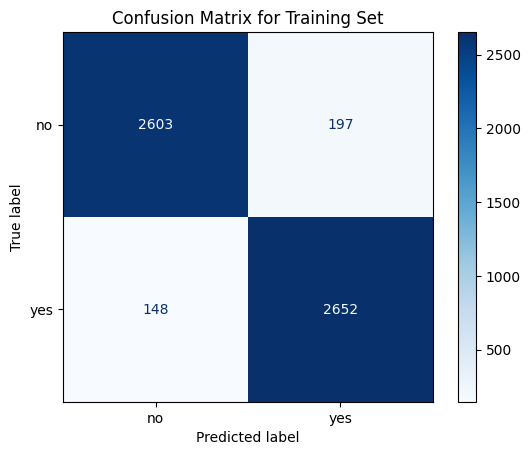


Metrics for Training Set:
Accuracy: 0.9384
Sensitivity: 0.9471
Specificity: 0.9296
Precision: 0.9309
F-measure: 0.9389

Confusion Matrix for Test Set:
[[1049  151]
 [  92 1108]]


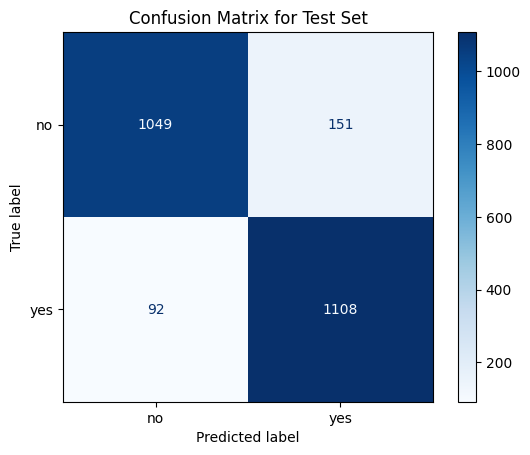


Metrics for Test Set:
Accuracy: 0.8988
Sensitivity: 0.9233
Specificity: 0.8742
Precision: 0.8801
F-measure: 0.9012


In [ ]:
#ALL ATTRIBUTES - USE THIS ONE

import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load your dataset (adjust path as necessary)
data = pd.read_csv('/content/bank.csv')

# Define relevant attributes for processing
attributes = data[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact',
                   'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(attributes.drop(columns=['y']))
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Add the target variable
encoded_df['y'] = attributes['y']

# Step 1: Separate majority ('no') and minority ('yes') classes
df_majority = encoded_df[encoded_df['y'] == 'no']
df_minority = encoded_df[encoded_df['y'] == 'yes']

# Print class distribution before oversampling
print("Before oversampling:")
print("Number of 'no' samples:", df_majority.shape[0])
print("Number of 'yes' samples:", df_minority.shape[0])

# Step 2: Oversample the minority class ('yes') to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(encoded_df.drop(columns=['y']), encoded_df['y'])

# Create balanced DataFrame
balanced_data = pd.DataFrame(X_resampled, columns=encoded_df.drop(columns=['y']).columns)
balanced_data['y'] = y_resampled

# Print class distribution after oversampling
df_majority_balanced = balanced_data[balanced_data['y'] == 'no']
df_minority_balanced = balanced_data[balanced_data['y'] == 'yes']
print("\nAfter oversampling:")
print("Number of 'no' samples:", df_majority_balanced.shape[0])
print("Number of 'yes' samples:", df_minority_balanced.shape[0])

# Step 3: Split into training (70%) and testing (30%) datasets
X = balanced_data.drop(columns=['y'])
y = balanced_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print number of rows in training and test sets
print("\nNumber of rows in training set:", X_train.shape[0])
print("Number of rows in test set:", X_test.shape[0])

# Initialize and train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Get feature log probabilities (log likelihood of each feature given each class)
feature_log_probs = nb.feature_log_prob_

# Convert log probabilities to regular probabilities for easier interpretation
feature_probs = np.exp(feature_log_probs)

# Calculate importance based on difference in probabilities between classes
importance = feature_probs[1] - feature_probs[0]  # Importance for the 'yes' class

# Create a DataFrame to show feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Print only top N important features
top_n = 10  # Number of top features to display
print(f"\nTop {top_n} Features based on Importance:")
print(importance_df.head(top_n))

# Alternatively, print features with importance greater than a certain threshold
threshold = 0.005  # Define your threshold value
print(f"\nFeatures with Importance Greater than {threshold}:")
print(importance_df[importance_df['Importance'] > threshold])

# Confusion Matrix for Training Set
print("\nConfusion Matrix for Training Set:")
cm_train = confusion_matrix(y_train, nb.predict(X_train), labels=['no', 'yes'])
print(cm_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['no', 'yes'])
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Calculate and print metrics for training set
def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f_measure = 2 * (precision * sensitivity) / (precision + sensitivity)
    return accuracy, sensitivity, specificity, precision, f_measure

accuracy_train, sensitivity_train, specificity_train, precision_train, f_measure_train = calculate_metrics(cm_train)
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Sensitivity: {sensitivity_train:.4f}")
print(f"Specificity: {specificity_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"F-measure: {f_measure_train:.4f}")

# Confusion Matrix for Test Set
print("\nConfusion Matrix for Test Set:")
cm_test = confusion_matrix(y_test, nb.predict(X_test), labels=['no', 'yes'])
print(cm_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['no', 'yes'])
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Calculate and print metrics for test set
accuracy_test, sensitivity_test, specificity_test, precision_test, f_measure_test = calculate_metrics(cm_test)
print("\nMetrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Sensitivity: {sensitivity_test:.4f}")
print(f"Specificity: {specificity_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F-measure: {f_measure_test:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Before oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 521


<ipython-input-6-905c47e6f899>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_data['y'] = y_resampled



After oversampling:
Number of 'no' samples: 4000
Number of 'yes' samples: 4000

Number of rows in training set: 5600
Number of rows in test set: 2400

Top 10 Features based on Importance:
                 Feature  Importance
3697    poutcome_success    0.012893
78        marital_single    0.006737
80    education_tertiary    0.006457
70           job_retired    0.005825
3674          previous_2    0.005420
2475           month_oct    0.005108
3673          previous_1    0.003739
69        job_management    0.003652
3676          previous_4    0.003177
3696      poutcome_other    0.003147

Features with Importance Greater than 0.005:
                 Feature  Importance
3697    poutcome_success    0.012893
78        marital_single    0.006737
80    education_tertiary    0.006457
70           job_retired    0.005825
3674          previous_2    0.005420
2475           month_oct    0.005108

Confusion Matrix for Training Set:
[[2615  185]
 [  96 2704]]


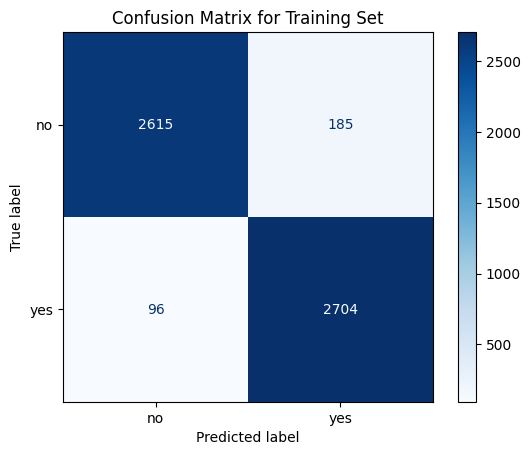


Metrics for Training Set:
Accuracy: 0.9498
Sensitivity: 0.9657
Specificity: 0.9339
Precision: 0.9360
F-measure: 0.9506

Confusion Matrix for Test Set:
[[1056  144]
 [  66 1134]]


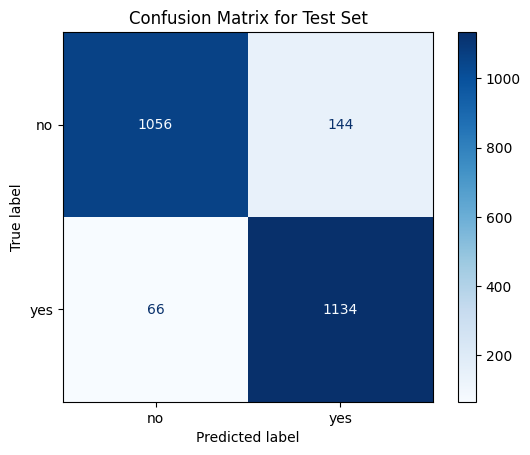


Metrics for Test Set:
Accuracy: 0.9125
Sensitivity: 0.9450
Specificity: 0.8800
Precision: 0.8873
F-measure: 0.9153


In [ ]:
#SELECTED ATTRIBUTES - USE THIS ONE - default out


import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load your dataset (adjust path as necessary)
data = pd.read_csv('/content/bank.csv')

# Define relevant attributes for processing
attributes = data[['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(attributes.drop(columns=['y']))
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Add the target variable
encoded_df['y'] = attributes['y']

# Step 1: Separate majority ('no') and minority ('yes') classes
df_majority = encoded_df[encoded_df['y'] == 'no']
df_minority = encoded_df[encoded_df['y'] == 'yes']

# Print class distribution before oversampling
print("Before oversampling:")
print("Number of 'no' samples:", df_majority.shape[0])
print("Number of 'yes' samples:", df_minority.shape[0])

# Step 2: Oversample the minority class ('yes') to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(encoded_df.drop(columns=['y']), encoded_df['y'])

# Create balanced DataFrame
balanced_data = pd.DataFrame(X_resampled, columns=encoded_df.drop(columns=['y']).columns)
balanced_data['y'] = y_resampled

# Print class distribution after oversampling
df_majority_balanced = balanced_data[balanced_data['y'] == 'no']
df_minority_balanced = balanced_data[balanced_data['y'] == 'yes']
print("\nAfter oversampling:")
print("Number of 'no' samples:", df_majority_balanced.shape[0])
print("Number of 'yes' samples:", df_minority_balanced.shape[0])

# Step 3: Split into training (70%) and testing (30%) datasets
X = balanced_data.drop(columns=['y'])
y = balanced_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print number of rows in training and test sets
print("\nNumber of rows in training set:", X_train.shape[0])
print("Number of rows in test set:", X_test.shape[0])

# Initialize and train Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Get feature log probabilities (log likelihood of each feature given each class)
feature_log_probs = nb.feature_log_prob_

# Convert log probabilities to regular probabilities for easier interpretation
feature_probs = np.exp(feature_log_probs)

# Calculate importance based on difference in probabilities between classes
importance = feature_probs[1] - feature_probs[0]  # Importance for the 'yes' class

# Create a DataFrame to show feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Print only top N important features
top_n = 10  # Number of top features to display
print(f"\nTop {top_n} Features based on Importance:")
print(importance_df.head(top_n))

# Alternatively, print features with importance greater than a certain threshold
threshold = 0.005  # Define your threshold value
print(f"\nFeatures with Importance Greater than {threshold}:")
print(importance_df[importance_df['Importance'] > threshold])

# Confusion Matrix for Training Set
print("\nConfusion Matrix for Training Set:")
cm_train = confusion_matrix(y_train, nb.predict(X_train), labels=['no', 'yes'])
print(cm_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['no', 'yes'])
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Calculate and print metrics for training set
def calculate_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f_measure = 2 * (precision * sensitivity) / (precision + sensitivity)
    return accuracy, sensitivity, specificity, precision, f_measure

accuracy_train, sensitivity_train, specificity_train, precision_train, f_measure_train = calculate_metrics(cm_train)
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Sensitivity: {sensitivity_train:.4f}")
print(f"Specificity: {specificity_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"F-measure: {f_measure_train:.4f}")

# Confusion Matrix for Test Set
print("\nConfusion Matrix for Test Set:")
cm_test = confusion_matrix(y_test, nb.predict(X_test), labels=['no', 'yes'])
print(cm_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['no', 'yes'])
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Calculate and print metrics for test set
accuracy_test, sensitivity_test, specificity_test, precision_test, f_measure_test = calculate_metrics(cm_test)
print("\nMetrics for Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Sensitivity: {sensitivity_test:.4f}")
print(f"Specificity: {specificity_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F-measure: {f_measure_test:.4f}")